In [99]:
# size dist plus growth rates
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline
from scipy.stats import norm
from scipy.stats import pareto

import pandas as pd

from scipy.special import erf


In [2]:
# Plan.


# from size dist and N, I should have n(q, Q). 

# The size dists are:
#  - Lognormal clipped x > 3. 
sigma = 1.3149476902828778
mu = 4.470439741406725

# 13% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

#  - Pareto on the 90% value, small percent of 

### Empirical number of agents and total value
Recommendation: 

1e5 agents. 

~1e11.5 EUR annually 

In [3]:
data_path = './../../data/processed/'

df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]
empirical = df.groupby(['YEAR']).agg({'ID': 'count', 'VART': 'sum'}) # count == nunique

In [4]:
# We'll try different N's, until we can match the avg level of France imports 

tot_val = []
Ns = np.array(np.round(np.power(10, np.arange(4.5, 5.5, .01))), dtype = int)

for N in Ns:
    N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
    draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
    draw = np.sort(draw)[-N:]
    tot_val += [np.power(10, draw).sum()] # (=y)

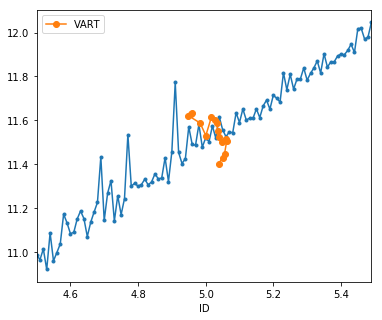

In [5]:
fig, ax = plt.subplots(1, figsize = (6, 5))

ax.plot(np.log10(Ns), np.log10(tot_val), marker = '.')
np.log10(empirical).plot('ID', 'VART', marker = 'o', ax = ax)
plt.show()
# *think that mu, sigma are for pooled data, but they could be different in each year.

## Size distributions

In [71]:
N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
draw = np.sort(draw)[-N:]

In [81]:
# From the theoretical N and the ppf we can know the theoretical quantiles
x1 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x1 = x1[(-N - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x1, 10)[1][1:].sum()

In [9]:
# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

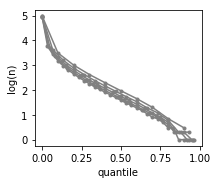

In [13]:
fig, ax = plt.subplots(1, figsize = (3, 2.5))

for Q in [10, 15, 20, 25, 30]:
    ns = get_n(x1, Q)[1]
    ax.plot(np.arange(Q)/Q, np.log10(ns), marker = '.', c = '.5')
plt.xlabel('quantile')
plt.ylabel('log(n)')
plt.show()


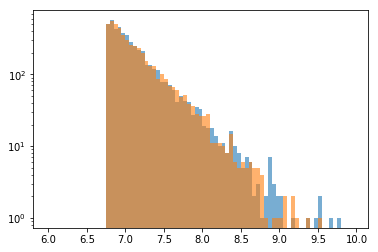

In [233]:
n = N_tail

bins_ = np.arange(6, 10, .05)
z_0 = -1.1771
value_qs_1 = 6.761
pareto_array = np.log10(np.random.pareto(-z_0, n) + 1 ) + value_qs_1
plt.hist(pareto_array, bins_, alpha = .6)

r = np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
plt.hist(r, bins_, alpha = .6)

plt.yscale('log')
plt.show()

In [ ]:
# pareto.pdf(x, b, loc, scale)
# pareto.pdf((x - loc) / scale, b) / scale

In [237]:
# Need to reconciliate... For the moment I use quick and dirty... just sort the random generated..
# x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1) for q in np.arange(0, 1, 1/N_tail) + .5/N_tail])
# np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
# x1 = x1[(-N_tail - 1):-1]

pareto_array = np.log10(np.random.pareto(-z_0, N_tail) + 1 ) + value_qs_1
# pareto_array = np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
x1 = np.sort(pareto_array)

## Empirical GR

In [14]:
gr_info = pd.read_csv('./../../data/processed/g_rates_info.csv')

In [20]:
T = 16
x0 = pd.Series(draw)
g_rates_list = []

# size dependent growth rates
for s in np.arange(3, 11.5, .5):
    x0_s = x0.loc[abs(x0 - s) < .25]
    gr_s = gr_info.loc[abs(gr_info.level - s) < .5]  
    
    if len(gr_s) > 0:
        g_rates_long = gr_s.sample(len(x0_s) * int(T/2), replace = True)
        g_rates = g_rates_long[['logdiff1', 'logdiff2']].values.reshape(len(x0_s), T)
        g_rates_list += [g_rates]
    
g_rates = pd.DataFrame(np.vstack(g_rates_list))

# If T is made many x T we could have repetitions with little effort...

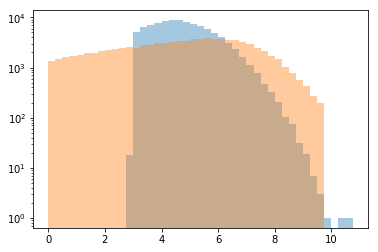

In [21]:
plt.hist(x0.values, np.arange(0, 11, .25), alpha = .4)
plt.hist(x0.values + g_rates.cumsum(axis = 1)[15], np.arange(0, 10, .25), alpha = .4)
plt.yscale('log')
plt.show()

In [22]:
# There is some issue, distribution gets deformed over time.

## Modeled GR
- Non correlated
    - Gaussian (a = 2)
    - Laplace (a = 1)
    - Subbotin (a = 1/2)

In [238]:
# x0 = pd.Series(draw)
# x1 is the exact distribution

N = N_tail

for s in [.1, .2, .3, .4, .5]:
    print(s)
    var_result = []
    for Q in [10, 15, 20, 25]:
        print(Q)
        bins, ns = get_n(x1, Q)
        I = 1000
        for i in range(I):
            if i%100 == 0: print(i)
            g_rates = np.random.normal(0, s, (N, T)) # # If T is made many x T we could have repetitions with little effort...

            gr_cs = g_rates.cumsum(axis = 1)
            gr_cs = (gr_cs.T - gr_cs.mean(axis = 1)).T
            xt = (gr_cs.T + x1).T

            st = np.power(10, xt)
            lin_levs = pd.DataFrame(st, index = bins)
            bin_ix_mapper = dict(zip(bins.unique(), range(bins.nunique())))
            lin_levs.index = lin_levs.index.map(bin_ix_mapper); lin_levs.index.name = 'q'

            # see if quantiles tend to have more or less a constant part ofthe value
            # df.groupby(level = 0).sum().reset_index(drop = True).T.plot()

            # The sum of this simulated quantile q, Q, i
            lin_levs_i = lin_levs.groupby(level = 0).sum()
            # The key line. # Variance of each quantile. 
            out_df = lin_levs_i
            out_df['var_qi'] = np.log10(lin_levs_i).var(axis = 1)
            out_df['i'] = i
            out_df['Q'] = Q
            out_df['var_agg_i'] = np.log10(lin_levs.sum()).var()
            out_df = out_df.reset_index()
            var_result += [out_df]

    result = pd.concat(var_result).reset_index(drop = True)
#     result.to_csv('./../../data/processed/exp_var_norm_1s_s'+str(s)+'.csv', index = False)
#     result.to_csv('./../../data/processed/exp_var_norm_1s_s'+str(s)+'_lntail.csv', index = False)
    result.to_csv('./../../data/processed/exp_var_norm_1s_s'+str(s)+'_pareto.csv', index = False)

        # Histogram of size dist diffusion
        # plt.hist(x1, np.arange(0, 10, .1), alpha = .4)
        # plt.hist(xt[:, 15], np.arange(0, 10, .1), alpha = .4)
        # plt.yscale('log')
        # plt.show()

#         plt.plot(ns, var_qi, marker = '.')
#         plt.xscale('log')
#         plt.yscale('log')

0.1
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.2
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.3
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.4
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.5
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900


## Laplace

In [239]:
# x0 = pd.Series(draw)
# x1 is the exact distribution

# size dependent growth rates
for s in [.1, .2, .3, .4, .5]:
    print(s)
    var_result = []
    for Q in [10, 15, 20, 25]:
        print(Q)
        bins, ns = get_n(x1, Q)
        I = 1000
        for i in range(I):
            if i%100 == 0: print(i)
#             g_rates = np.random.normal(0, s, (N, T)) # # If T is made many x T we could have repetitions with little effort...
            g_rates = np.random.laplace(0, s, (N, T))/np.sqrt(2) # Normalization for having the right sigma
            
            gr_cs = g_rates.cumsum(axis = 1)
            gr_cs = (gr_cs.T - gr_cs.mean(axis = 1)).T
            xt = (gr_cs.T + x1).T

            st = np.power(10, xt)
            lin_levs = pd.DataFrame(st, index = bins)
            bin_ix_mapper = dict(zip(bins.unique(), range(bins.nunique())))
            lin_levs.index = lin_levs.index.map(bin_ix_mapper); lin_levs.index.name = 'q'

            # see if quantiles tend to have more or less a constant part ofthe value
            # df.groupby(level = 0).sum().reset_index(drop = True).T.plot()

            # The sum of this simulated quantile q, Q, i
            lin_levs_i = lin_levs.groupby(level = 0).sum()
            # The key line. # Variance of each quantile. 
            out_df = lin_levs_i
            out_df['var_qi'] = np.log10(lin_levs_i).var(axis = 1)
            out_df['i'] = i
            out_df['Q'] = Q
            out_df['var_agg_i'] = np.log10(lin_levs.sum()).var()
            out_df = out_df.reset_index()
            var_result += [out_df]

    result = pd.concat(var_result).reset_index(drop = True)
#     result.to_csv('./../../data/processed/exp_var_lapl_1s_s'+str(s)+'_lntail.csv', index = False)
#     result.to_csv('./../../data/processed/exp_var_lapl_1s_s'+str(s)+'.csv', index = False)
    result.to_csv('./../../data/processed/exp_var_norm_1s_s'+str(s)+'_pareto.csv', index = False)


        # Histogram of size dist diffusion
        # plt.hist(x1, np.arange(0, 10, .1), alpha = .4)
        # plt.hist(xt[:, 15], np.arange(0, 10, .1), alpha = .4)
        # plt.yscale('log')
        # plt.show()

#         plt.plot(ns, var_qi, marker = '.')
#         plt.xscale('log')
#         plt.yscale('log')

0.1
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.2
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.3
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.4
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.5
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900


## Generalized normal / Subbotin

In [240]:
from scipy.stats import gennorm

In [241]:
# x0 = pd.Series(draw)
# x1 is the exact distribution

# size dependent growth rates
for s in [.1, .2, .3, .4, .5]:
    print(s)
    var_result = []
    for Q in [10, 15, 20, 25]:
        print(Q)
        bins, ns = get_n(x1, Q)
        I = 1000
        for i in range(I):
            if i%100 == 0: print(i)
#             g_rates = np.random.normal(0, s, (N, T)) # # If T is made many x T we could have repetitions with little effort...
            g_rates = gennorm.rvs(1/2, size = (N, T))
            g_rates = s*g_rates/g_rates.flatten().std()

            gr_cs = g_rates.cumsum(axis = 1)
            gr_cs = (gr_cs.T - gr_cs.mean(axis = 1)).T
            xt = (gr_cs.T + x1).T

            st = np.power(10, xt)
            lin_levs = pd.DataFrame(st, index = bins)
            bin_ix_mapper = dict(zip(bins.unique(), range(bins.nunique())))
            lin_levs.index = lin_levs.index.map(bin_ix_mapper); lin_levs.index.name = 'q'

            # see if quantiles tend to have more or less a constant part ofthe value
            # df.groupby(level = 0).sum().reset_index(drop = True).T.plot()

            # The sum of this simulated quantile q, Q, i
            lin_levs_i = lin_levs.groupby(level = 0).sum()
            # The key line. # Variance of each quantile. 
            out_df = lin_levs_i
            out_df['var_qi'] = np.log10(lin_levs_i).var(axis = 1)
            out_df['i'] = i
            out_df['Q'] = Q
            out_df['var_agg_i'] = np.log10(lin_levs.sum()).var()
            out_df = out_df.reset_index()
            var_result += [out_df]

    result = pd.concat(var_result).reset_index(drop = True)
#     result.to_csv('./../../data/processed/exp_var_sbtn_1s_s'+str(s)+'_lntail.csv', index = False)
#     result.to_csv('./../../data/processed/exp_var_sbtn_1s_s'+str(s)+'.csv', index = False)
    result.to_csv('./../../data/processed/exp_var_norm_1s_s'+str(s)+'_pareto.csv', index = False)

        # Histogram of size dist diffusion
        # plt.hist(x1, np.arange(0, 10, .1), alpha = .4)
        # plt.hist(xt[:, 15], np.arange(0, 10, .1), alpha = .4)
        # plt.yscale('log')
        # plt.show()

#         plt.plot(ns, var_qi, marker = '.')
#         plt.xscale('log')
#         plt.yscale('log')

0.1
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.2
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.3
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.4
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900
0.5
10
0
100
200
300
400
500
600
700
800
900
15
0
100
200
300
400
500
600
700
800
900
20
0
100
200
300
400
500
600
700
800
900
25
0
100
200
300
400
500
600
700
800
900


In [94]:
#